In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Umpire", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Umpire", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Umpire", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1728
Total validation images: 468
Total test images: 585
Total images in dataset: 2781


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1536
Validation images (excluding 'random_occlusion'): 416
Test images (excluding 'random_occlusion'): 520
Total images (excluding 'random_occlusion'): 2472


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'motion_blur', 'blur', 'chromatic_aberration', 'random_occlusion', 'low_resolution', 'dirty_lens', 'lens_flare', 'original', 'gaussian_noise'}
Validation folders considered: {'motion_blur', 'blur', 'chromatic_aberration', 'random_occlusion', 'low_resolution', 'dirty_lens', 'lens_flare', 'original', 'gaussian_noise'}
Test folders considered: {'motion_blur', 'blur', 'chromatic_aberration', 'random_occlusion', 'low_resolution', 'dirty_lens', 'lens_flare', 'original', 'gaussian_noise'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Umpire", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Umpire", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Umpire", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']
Final Training images: 1536
Final Validation images: 416
Final Test images: 520
Total images after filtering: 2472


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'motion_blur', 'blur', 'chromatic_aberration', 'low_resolution', 'dirty_lens', 'lens_flare', 'original', 'gaussian_noise'}
Validation folders considered: {'motion_blur', 'blur', 'chromatic_aberration', 'low_resolution', 'dirty_lens', 'lens_flare', 'original', 'gaussian_noise'}
Test folders considered: {'motion_blur', 'blur', 'chromatic_aberration', 'low_resolution', 'dirty_lens', 'lens_flare', 'original', 'gaussian_noise'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

classes = train_ds.classes
print("Classes:", classes)
print(f"Number of classes: {len(classes)}")
print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

# -----------------------------
# 2. Pretrained MobileNetV2 Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained MobileNetV2
print("üîÑ Loading pretrained MobileNetV2 from ImageNet...")
model = models.mobilenet_v2(pretrained=True)

# Replace final classification layer
# MobileNetV2 has a different structure: model.classifier[1] instead of model.fc
num_features = model.classifier[1].in_features  # Get input features (1280)
model.classifier[1] = nn.Linear(num_features, len(classes))  # Replace final layer
model = model.to(device)

print(f"‚úÖ Model loaded with {len(classes)} output classes")
print(f"üìä Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"üìä Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Model summary
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary not available")



Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']
Number of classes: 6
Train samples: 1536
Val samples: 416
Test samples: 520
Using device: cuda
üîÑ Loading pretrained MobileNetV2 from ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13.6M/13.6M [00:00<00:00, 124MB/s]


‚úÖ Model loaded with 6 output classes
üìä Total parameters: 2,231,558
üìä Trainable parameters: 2,231,558
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]           


üìã Training Configuration:
‚îÇ Model: MobileNetV2 (pretrained)
‚îÇ Optimizer: Adam (lr=0.0001)
‚îÇ Loss Function: CrossEntropyLoss
‚îÇ Batch Size: 32
‚îÇ Device: cuda

üöÄ Starting MobileNetV2 Fine-tuning for 50 epochs...

üìà Epoch 1/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:21<00:00,  2.24it/s, Loss=1.0405, Acc=0.6361]


‚úÖ Training completed in 21.47s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:04<00:00,  3.14it/s, Loss=0.8659, Acc=0.6923]


‚úÖ Validation completed in 4.14s
üåü New best model found! Validation Loss: 0.8659

üìä Epoch 1 Summary:
‚îÇ Train Loss: 1.0405 | Train Acc: 0.6361
‚îÇ Val Loss:   0.8659 | Val Acc:   0.6923
‚îÇ Train Time: 21.47s | Val Time: 4.14s
‚îÇ Total Epoch Time: 25.61s
‚îÇ Best Val Loss: 0.8659 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 2/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.06it/s, Loss=0.2373, Acc=0.9583]


‚úÖ Training completed in 15.69s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.63it/s, Loss=0.6860, Acc=0.7692]


‚úÖ Validation completed in 2.81s
üåü New best model found! Validation Loss: 0.6860

üìä Epoch 2 Summary:
‚îÇ Train Loss: 0.2373 | Train Acc: 0.9583
‚îÇ Val Loss:   0.6860 | Val Acc:   0.7692
‚îÇ Train Time: 15.69s | Val Time: 2.81s
‚îÇ Total Epoch Time: 18.51s
‚îÇ Best Val Loss: 0.6860 (Epoch 2)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 3/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.04it/s, Loss=0.0515, Acc=0.9967]


‚úÖ Training completed in 15.77s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.56it/s, Loss=0.6809, Acc=0.7909]


‚úÖ Validation completed in 2.85s
üåü New best model found! Validation Loss: 0.6809

üìä Epoch 3 Summary:
‚îÇ Train Loss: 0.0515 | Train Acc: 0.9967
‚îÇ Val Loss:   0.6809 | Val Acc:   0.7909
‚îÇ Train Time: 15.77s | Val Time: 2.85s
‚îÇ Total Epoch Time: 18.62s
‚îÇ Best Val Loss: 0.6809 (Epoch 3)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 4/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.03it/s, Loss=0.0202, Acc=0.9987]


‚úÖ Training completed in 15.86s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.62it/s, Loss=0.7199, Acc=0.7764]


‚úÖ Validation completed in 2.82s

üìä Epoch 4 Summary:
‚îÇ Train Loss: 0.0202 | Train Acc: 0.9987
‚îÇ Val Loss:   0.7199 | Val Acc:   0.7764
‚îÇ Train Time: 15.86s | Val Time: 2.82s
‚îÇ Total Epoch Time: 18.68s
‚îÇ Best Val Loss: 0.6809 (Epoch 3)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 5/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.04it/s, Loss=0.0114, Acc=1.0000]


‚úÖ Training completed in 15.81s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.69it/s, Loss=0.6953, Acc=0.7981]


‚úÖ Validation completed in 2.77s

üìä Epoch 5 Summary:
‚îÇ Train Loss: 0.0114 | Train Acc: 1.0000
‚îÇ Val Loss:   0.6953 | Val Acc:   0.7981
‚îÇ Train Time: 15.81s | Val Time: 2.77s
‚îÇ Total Epoch Time: 18.58s
‚îÇ Best Val Loss: 0.6809 (Epoch 3)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 6/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.11it/s, Loss=0.0072, Acc=1.0000]


‚úÖ Training completed in 15.46s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.62it/s, Loss=0.6786, Acc=0.8005]


‚úÖ Validation completed in 2.82s
üåü New best model found! Validation Loss: 0.6786

üìä Epoch 6 Summary:
‚îÇ Train Loss: 0.0072 | Train Acc: 1.0000
‚îÇ Val Loss:   0.6786 | Val Acc:   0.8005
‚îÇ Train Time: 15.46s | Val Time: 2.82s
‚îÇ Total Epoch Time: 18.45s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 7/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.03it/s, Loss=0.0060, Acc=1.0000]


‚úÖ Training completed in 15.83s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.72it/s, Loss=0.6910, Acc=0.7957]


‚úÖ Validation completed in 2.76s

üìä Epoch 7 Summary:
‚îÇ Train Loss: 0.0060 | Train Acc: 1.0000
‚îÇ Val Loss:   0.6910 | Val Acc:   0.7957
‚îÇ Train Time: 15.83s | Val Time: 2.76s
‚îÇ Total Epoch Time: 18.59s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 8/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.01it/s, Loss=0.0032, Acc=1.0000]


‚úÖ Training completed in 15.96s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.53it/s, Loss=0.7239, Acc=0.7837]


‚úÖ Validation completed in 2.87s

üìä Epoch 8 Summary:
‚îÇ Train Loss: 0.0032 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7239 | Val Acc:   0.7837
‚îÇ Train Time: 15.96s | Val Time: 2.87s
‚îÇ Total Epoch Time: 18.83s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 9/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.02it/s, Loss=0.0029, Acc=1.0000]


‚úÖ Training completed in 15.87s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.79it/s, Loss=0.7299, Acc=0.7957]


‚úÖ Validation completed in 2.72s

üìä Epoch 9 Summary:
‚îÇ Train Loss: 0.0029 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7299 | Val Acc:   0.7957
‚îÇ Train Time: 15.87s | Val Time: 2.72s
‚îÇ Total Epoch Time: 18.60s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 10/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.01it/s, Loss=0.0019, Acc=1.0000]


‚úÖ Training completed in 15.94s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.47it/s, Loss=0.7261, Acc=0.7885]


‚úÖ Validation completed in 2.91s

üìä Epoch 10 Summary:
‚îÇ Train Loss: 0.0019 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7261 | Val Acc:   0.7885
‚îÇ Train Time: 15.94s | Val Time: 2.91s
‚îÇ Total Epoch Time: 18.86s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 11/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.97it/s, Loss=0.0023, Acc=1.0000]


‚úÖ Training completed in 16.18s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.53it/s, Loss=0.7196, Acc=0.7957]


‚úÖ Validation completed in 2.88s

üìä Epoch 11 Summary:
‚îÇ Train Loss: 0.0023 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7196 | Val Acc:   0.7957
‚îÇ Train Time: 16.18s | Val Time: 2.88s
‚îÇ Total Epoch Time: 19.06s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 12/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.00it/s, Loss=0.0017, Acc=1.0000]


‚úÖ Training completed in 15.98s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.68it/s, Loss=0.7317, Acc=0.8077]


‚úÖ Validation completed in 2.78s

üìä Epoch 12 Summary:
‚îÇ Train Loss: 0.0017 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7317 | Val Acc:   0.8077
‚îÇ Train Time: 15.98s | Val Time: 2.78s
‚îÇ Total Epoch Time: 18.76s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 13/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.03it/s, Loss=0.0023, Acc=1.0000]


‚úÖ Training completed in 15.86s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.80it/s, Loss=0.7285, Acc=0.8029]


‚úÖ Validation completed in 2.71s

üìä Epoch 13 Summary:
‚îÇ Train Loss: 0.0023 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7285 | Val Acc:   0.8029
‚îÇ Train Time: 15.86s | Val Time: 2.71s
‚îÇ Total Epoch Time: 18.58s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 14/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.02it/s, Loss=0.0017, Acc=1.0000]


‚úÖ Training completed in 15.88s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.69it/s, Loss=0.7548, Acc=0.7981]


‚úÖ Validation completed in 2.78s

üìä Epoch 14 Summary:
‚îÇ Train Loss: 0.0017 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7548 | Val Acc:   0.7981
‚îÇ Train Time: 15.88s | Val Time: 2.78s
‚îÇ Total Epoch Time: 18.66s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 15/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.04it/s, Loss=0.0011, Acc=1.0000]


‚úÖ Training completed in 15.77s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.77it/s, Loss=0.7306, Acc=0.8101]


‚úÖ Validation completed in 2.73s

üìä Epoch 15 Summary:
‚îÇ Train Loss: 0.0011 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7306 | Val Acc:   0.8101
‚îÇ Train Time: 15.77s | Val Time: 2.73s
‚îÇ Total Epoch Time: 18.50s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 16/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.97it/s, Loss=0.0010, Acc=1.0000]


‚úÖ Training completed in 16.14s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.69it/s, Loss=0.7254, Acc=0.8005]


‚úÖ Validation completed in 2.77s

üìä Epoch 16 Summary:
‚îÇ Train Loss: 0.0010 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7254 | Val Acc:   0.8005
‚îÇ Train Time: 16.14s | Val Time: 2.77s
‚îÇ Total Epoch Time: 18.92s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 17/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.00it/s, Loss=0.0015, Acc=1.0000]


‚úÖ Training completed in 15.99s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.46it/s, Loss=0.7631, Acc=0.8005]


‚úÖ Validation completed in 2.92s

üìä Epoch 17 Summary:
‚îÇ Train Loss: 0.0015 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7631 | Val Acc:   0.8005
‚îÇ Train Time: 15.99s | Val Time: 2.92s
‚îÇ Total Epoch Time: 18.91s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 18/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.01it/s, Loss=0.0008, Acc=1.0000]


‚úÖ Training completed in 15.93s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.69it/s, Loss=0.7112, Acc=0.8173]


‚úÖ Validation completed in 2.77s

üìä Epoch 18 Summary:
‚îÇ Train Loss: 0.0008 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7112 | Val Acc:   0.8173
‚îÇ Train Time: 15.93s | Val Time: 2.77s
‚îÇ Total Epoch Time: 18.70s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 19/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  3.00it/s, Loss=0.0009, Acc=1.0000]


‚úÖ Training completed in 16.00s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.70it/s, Loss=0.7312, Acc=0.8053]


‚úÖ Validation completed in 2.77s

üìä Epoch 19 Summary:
‚îÇ Train Loss: 0.0009 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7312 | Val Acc:   0.8053
‚îÇ Train Time: 16.00s | Val Time: 2.77s
‚îÇ Total Epoch Time: 18.77s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 20/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  3.00it/s, Loss=0.0008, Acc=1.0000]


‚úÖ Training completed in 16.03s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.75it/s, Loss=0.7534, Acc=0.8029]


‚úÖ Validation completed in 2.74s

üìä Epoch 20 Summary:
‚îÇ Train Loss: 0.0008 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7534 | Val Acc:   0.8029
‚îÇ Train Time: 16.03s | Val Time: 2.74s
‚îÇ Total Epoch Time: 18.77s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 21/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  3.00it/s, Loss=0.0007, Acc=1.0000]


‚úÖ Training completed in 16.03s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.57it/s, Loss=0.8161, Acc=0.8029]


‚úÖ Validation completed in 2.85s

üìä Epoch 21 Summary:
‚îÇ Train Loss: 0.0007 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8161 | Val Acc:   0.8029
‚îÇ Train Time: 16.03s | Val Time: 2.85s
‚îÇ Total Epoch Time: 18.88s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 22/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.02it/s, Loss=0.0007, Acc=1.0000]


‚úÖ Training completed in 15.92s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.68it/s, Loss=0.7915, Acc=0.8029]


‚úÖ Validation completed in 2.78s

üìä Epoch 22 Summary:
‚îÇ Train Loss: 0.0007 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7915 | Val Acc:   0.8029
‚îÇ Train Time: 15.92s | Val Time: 2.78s
‚îÇ Total Epoch Time: 18.70s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 23/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.00it/s, Loss=0.0005, Acc=1.0000]


‚úÖ Training completed in 16.00s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.74it/s, Loss=0.7780, Acc=0.8077]


‚úÖ Validation completed in 2.74s

üìä Epoch 23 Summary:
‚îÇ Train Loss: 0.0005 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7780 | Val Acc:   0.8077
‚îÇ Train Time: 16.00s | Val Time: 2.74s
‚îÇ Total Epoch Time: 18.74s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 24/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.99it/s, Loss=0.0004, Acc=1.0000]


‚úÖ Training completed in 16.08s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.58it/s, Loss=0.7745, Acc=0.8005]


‚úÖ Validation completed in 2.84s

üìä Epoch 24 Summary:
‚îÇ Train Loss: 0.0004 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7745 | Val Acc:   0.8005
‚îÇ Train Time: 16.08s | Val Time: 2.84s
‚îÇ Total Epoch Time: 18.92s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 25/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  3.00it/s, Loss=0.0005, Acc=1.0000]


‚úÖ Training completed in 16.03s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.63it/s, Loss=0.7816, Acc=0.8029]


‚úÖ Validation completed in 2.81s

üìä Epoch 25 Summary:
‚îÇ Train Loss: 0.0005 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7816 | Val Acc:   0.8029
‚îÇ Train Time: 16.03s | Val Time: 2.81s
‚îÇ Total Epoch Time: 18.84s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 26/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0004, Acc=1.0000]


‚úÖ Training completed in 16.21s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.62it/s, Loss=0.7955, Acc=0.8005]


‚úÖ Validation completed in 2.82s

üìä Epoch 26 Summary:
‚îÇ Train Loss: 0.0004 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7955 | Val Acc:   0.8005
‚îÇ Train Time: 16.21s | Val Time: 2.82s
‚îÇ Total Epoch Time: 19.03s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 27/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.97it/s, Loss=0.0006, Acc=1.0000]


‚úÖ Training completed in 16.16s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.48it/s, Loss=0.7907, Acc=0.8101]


‚úÖ Validation completed in 2.90s

üìä Epoch 27 Summary:
‚îÇ Train Loss: 0.0006 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7907 | Val Acc:   0.8101
‚îÇ Train Time: 16.16s | Val Time: 2.90s
‚îÇ Total Epoch Time: 19.06s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 28/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.95it/s, Loss=0.0010, Acc=1.0000]


‚úÖ Training completed in 16.25s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.69it/s, Loss=0.7551, Acc=0.8149]


‚úÖ Validation completed in 2.78s

üìä Epoch 28 Summary:
‚îÇ Train Loss: 0.0010 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7551 | Val Acc:   0.8149
‚îÇ Train Time: 16.25s | Val Time: 2.78s
‚îÇ Total Epoch Time: 19.03s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 29/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.98it/s, Loss=0.0006, Acc=1.0000]


‚úÖ Training completed in 16.12s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.63it/s, Loss=0.7763, Acc=0.8053]


‚úÖ Validation completed in 2.81s

üìä Epoch 29 Summary:
‚îÇ Train Loss: 0.0006 | Train Acc: 1.0000
‚îÇ Val Loss:   0.7763 | Val Acc:   0.8053
‚îÇ Train Time: 16.12s | Val Time: 2.81s
‚îÇ Total Epoch Time: 18.93s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 30/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0008, Acc=1.0000]


‚úÖ Training completed in 16.21s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.63it/s, Loss=0.8183, Acc=0.8125]


‚úÖ Validation completed in 2.82s

üìä Epoch 30 Summary:
‚îÇ Train Loss: 0.0008 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8183 | Val Acc:   0.8125
‚îÇ Train Time: 16.21s | Val Time: 2.82s
‚îÇ Total Epoch Time: 19.03s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 31/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.97it/s, Loss=0.0004, Acc=1.0000]


‚úÖ Training completed in 16.17s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.77it/s, Loss=0.8794, Acc=0.8173]


‚úÖ Validation completed in 2.73s

üìä Epoch 31 Summary:
‚îÇ Train Loss: 0.0004 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8794 | Val Acc:   0.8173
‚îÇ Train Time: 16.17s | Val Time: 2.73s
‚îÇ Total Epoch Time: 18.90s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 32/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.92it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.42s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.54it/s, Loss=0.8458, Acc=0.8077]


‚úÖ Validation completed in 2.87s

üìä Epoch 32 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8458 | Val Acc:   0.8077
‚îÇ Train Time: 16.42s | Val Time: 2.87s
‚îÇ Total Epoch Time: 19.29s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 33/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.01it/s, Loss=0.0004, Acc=1.0000]


‚úÖ Training completed in 15.96s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.75it/s, Loss=0.8618, Acc=0.8125]


‚úÖ Validation completed in 2.74s

üìä Epoch 33 Summary:
‚îÇ Train Loss: 0.0004 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8618 | Val Acc:   0.8125
‚îÇ Train Time: 15.96s | Val Time: 2.74s
‚îÇ Total Epoch Time: 18.70s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 34/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  3.00it/s, Loss=0.0007, Acc=1.0000]


‚úÖ Training completed in 16.01s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.65it/s, Loss=0.8030, Acc=0.8149]


‚úÖ Validation completed in 2.80s

üìä Epoch 34 Summary:
‚îÇ Train Loss: 0.0007 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8030 | Val Acc:   0.8149
‚îÇ Train Time: 16.01s | Val Time: 2.80s
‚îÇ Total Epoch Time: 18.81s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 35/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:15<00:00,  3.00it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.00s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.65it/s, Loss=0.8226, Acc=0.8221]


‚úÖ Validation completed in 2.80s

üìä Epoch 35 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8226 | Val Acc:   0.8221
‚îÇ Train Time: 16.00s | Val Time: 2.80s
‚îÇ Total Epoch Time: 18.80s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 36/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.98it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.12s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.69it/s, Loss=0.8428, Acc=0.8053]


‚úÖ Validation completed in 2.77s

üìä Epoch 36 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8428 | Val Acc:   0.8053
‚îÇ Train Time: 16.12s | Val Time: 2.77s
‚îÇ Total Epoch Time: 18.89s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 37/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.98it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.12s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.73it/s, Loss=0.8457, Acc=0.8125]


‚úÖ Validation completed in 2.75s

üìä Epoch 37 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8457 | Val Acc:   0.8125
‚îÇ Train Time: 16.12s | Val Time: 2.75s
‚îÇ Total Epoch Time: 18.87s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 38/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.98it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.12s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:03<00:00,  4.16it/s, Loss=0.8199, Acc=0.8125]


‚úÖ Validation completed in 3.13s

üìä Epoch 38 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8199 | Val Acc:   0.8125
‚îÇ Train Time: 16.12s | Val Time: 3.13s
‚îÇ Total Epoch Time: 19.25s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 39/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.86it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.79s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.37it/s, Loss=0.8266, Acc=0.8149]


‚úÖ Validation completed in 2.97s

üìä Epoch 39 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8266 | Val Acc:   0.8149
‚îÇ Train Time: 16.79s | Val Time: 2.97s
‚îÇ Total Epoch Time: 19.77s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 40/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.85it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.87s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.41it/s, Loss=0.8315, Acc=0.8053]


‚úÖ Validation completed in 2.95s

üìä Epoch 40 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8315 | Val Acc:   0.8053
‚îÇ Train Time: 16.87s | Val Time: 2.95s
‚îÇ Total Epoch Time: 19.83s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 41/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.86it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.81s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.42it/s, Loss=0.8601, Acc=0.8101]


‚úÖ Validation completed in 2.94s

üìä Epoch 41 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8601 | Val Acc:   0.8101
‚îÇ Train Time: 16.81s | Val Time: 2.94s
‚îÇ Total Epoch Time: 19.75s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 42/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.83it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.95s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:03<00:00,  4.33it/s, Loss=0.8290, Acc=0.8149]


‚úÖ Validation completed in 3.01s

üìä Epoch 42 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8290 | Val Acc:   0.8149
‚îÇ Train Time: 16.95s | Val Time: 3.01s
‚îÇ Total Epoch Time: 19.96s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 43/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.86it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.76s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:03<00:00,  4.07it/s, Loss=0.8444, Acc=0.8125]


‚úÖ Validation completed in 3.19s

üìä Epoch 43 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8444 | Val Acc:   0.8125
‚îÇ Train Time: 16.76s | Val Time: 3.19s
‚îÇ Total Epoch Time: 19.96s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 44/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.91it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.52s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.44it/s, Loss=0.8660, Acc=0.8221]


‚úÖ Validation completed in 2.93s

üìä Epoch 44 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8660 | Val Acc:   0.8221
‚îÇ Train Time: 16.52s | Val Time: 2.93s
‚îÇ Total Epoch Time: 19.45s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 45/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.84it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.91s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:03<00:00,  4.26it/s, Loss=0.8369, Acc=0.8221]


‚úÖ Validation completed in 3.05s

üìä Epoch 45 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8369 | Val Acc:   0.8221
‚îÇ Train Time: 16.91s | Val Time: 3.05s
‚îÇ Total Epoch Time: 19.96s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 46/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:17<00:00,  2.81it/s, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 17.06s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:03<00:00,  4.24it/s, Loss=0.8385, Acc=0.8077]


‚úÖ Validation completed in 3.07s

üìä Epoch 46 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8385 | Val Acc:   0.8077
‚îÇ Train Time: 17.06s | Val Time: 3.07s
‚îÇ Total Epoch Time: 20.13s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 47/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.85it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.83s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.53it/s, Loss=0.8734, Acc=0.8077]


‚úÖ Validation completed in 2.87s

üìä Epoch 47 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8734 | Val Acc:   0.8077
‚îÇ Train Time: 16.83s | Val Time: 2.87s
‚îÇ Total Epoch Time: 19.70s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 48/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.89it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.63s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:03<00:00,  4.31it/s, Loss=0.8803, Acc=0.8125]


‚úÖ Validation completed in 3.02s

üìä Epoch 48 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8803 | Val Acc:   0.8125
‚îÇ Train Time: 16.63s | Val Time: 3.02s
‚îÇ Total Epoch Time: 19.64s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 49/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.87it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.71s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:02<00:00,  4.46it/s, Loss=0.8744, Acc=0.8101]


‚úÖ Validation completed in 2.92s

üìä Epoch 49 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8744 | Val Acc:   0.8101
‚îÇ Train Time: 16.71s | Val Time: 2.92s
‚îÇ Total Epoch Time: 19.63s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 50/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.87it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.73s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13/13 [00:03<00:00,  4.31it/s, Loss=0.8714, Acc=0.8173]


‚úÖ Validation completed in 3.02s

üìä Epoch 50 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   0.8714 | Val Acc:   0.8173
‚îÇ Train Time: 16.73s | Val Time: 3.02s
‚îÇ Total Epoch Time: 19.76s
‚îÇ Best Val Loss: 0.6786 (Epoch 6)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üíæ Best model saved as 'best_cricket_mobilenetv2.pth'
üìä Best model stats:
‚îÇ Best Epoch: 6
‚îÇ Best Val Loss: 0.6786
‚îÇ Best Val Acc: 0.8005

üíæ Training history saved to 'cricket_mobilenetv2_history_pretrained.csv'

üéâ MobileNetV2 Fine-tuning Complete!
Total Training Time: 959.23s (16.0 minutes)
Average Epoch Time: 19.18s

üß™ Loading Best Model for Testing...
‚úÖ Best model from epoch 6 loaded successfully!


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 17/17 [00:06<00:00,  2.73it/s]


‚úÖ Testing completed in 6.23s

üìã Classification Report:
              precision    recall  f1-score   support

        Four       0.06      0.05      0.05        40
     Leg_Bye       0.73      0.60      0.66        40
     No_ball       0.51      0.60      0.55       104
         Out       0.71      0.67      0.69        48
         Six       0.92      0.88      0.90       152
        Wide       0.71      0.73      0.72       136

    accuracy                           0.68       520
   macro avg       0.61      0.59      0.59       520
weighted avg       0.68      0.68      0.68       520

üéØ Test Accuracy: 0.6769

üìä Cricket Classification Performance (MobileNetV2):
‚îÇ Best Validation Loss: 0.6786 (Epoch 6)
‚îÇ Best Validation Acc:  0.8005 (Epoch 6)
‚îÇ Final Test Accuracy:  0.6769
‚îÇ Val-Test Gap:         0.1236

üíæ Files saved:
‚îÇ best_cricket_mobilenetv2.pth - Best model weights
‚îÇ cricket_mobilenetv2_history.csv - Training metrics


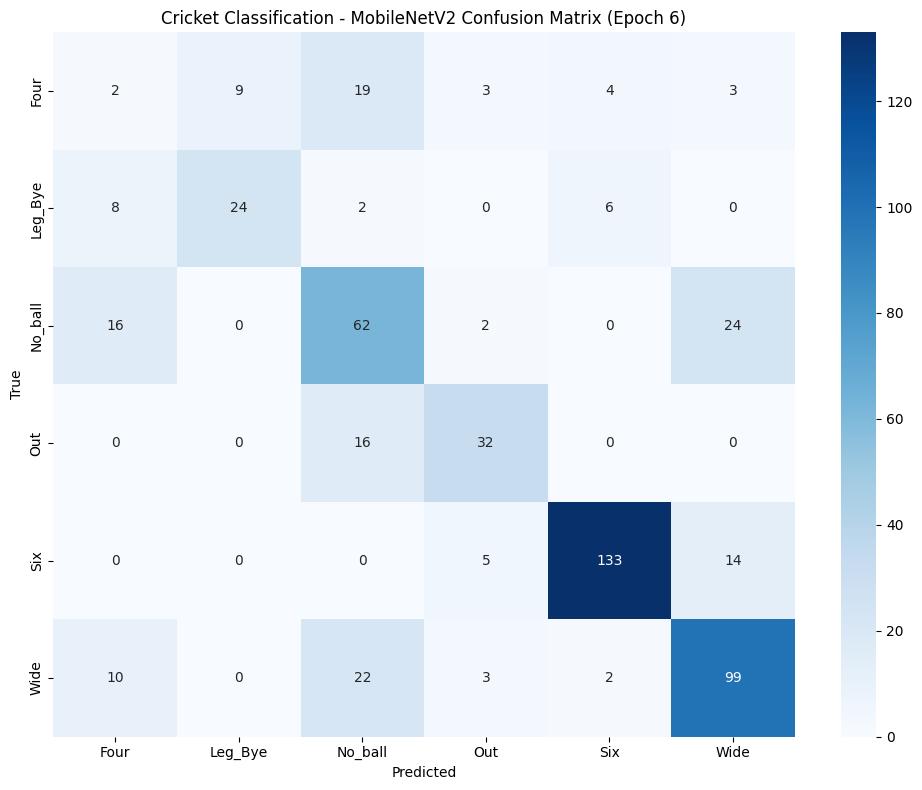

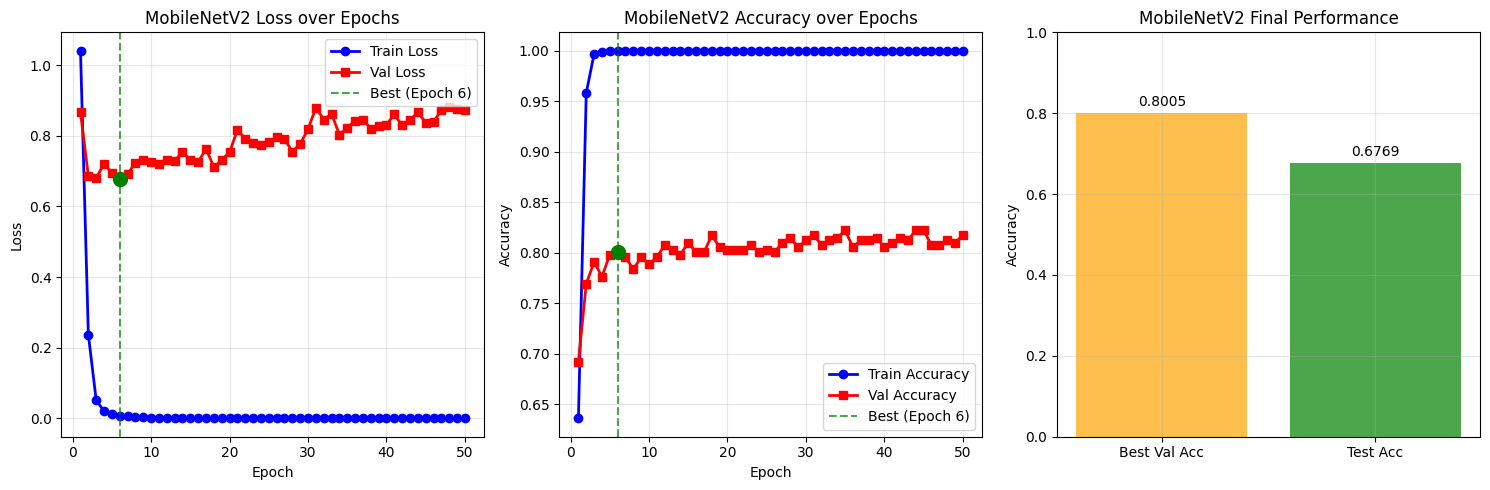


‚è∞ Final Timing Summary:
‚îÇ Total Training: 959.23s (16.0 min)
‚îÇ Average per Epoch: 19.18s
‚îÇ Testing Time: 6.23s
‚îÇ Total Runtime: 965.45s

üì± MobileNetV2 Advantages:
‚îÇ Lightweight: ~3.5M parameters vs ~25M (ResNet50)
‚îÇ Mobile-optimized: Designed for resource-constrained devices
‚îÇ Faster training: Typically trains faster than ResNet50
‚îÇ Lower memory: Uses less GPU memory during training


In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\nüìã Training Configuration:")
print(f"‚îÇ Model: MobileNetV2 (pretrained)")
print(f"‚îÇ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"‚îÇ Loss Function: CrossEntropyLoss")
print(f"‚îÇ Batch Size: 32")
print(f"‚îÇ Device: {device}")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\nüöÄ Starting MobileNetV2 Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\nüìà Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("üîÑ Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"‚úÖ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("üîç Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"‚úÖ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"üåü New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\nüìä Epoch {epoch+1} Summary:")
    print(f"‚îÇ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"‚îÇ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"‚îÇ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"‚îÇ Total Epoch Time: {epoch_time:.2f}s")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"‚îÇ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_mobilenetv2_pretrained.pth')
    print(f"\nüíæ Best model saved as 'best_cricket_mobilenetv2.pth'")
    print(f"üìä Best model stats:")
    print(f"‚îÇ Best Epoch: {best_epoch}")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f}")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_mobilenetv2_history_pretrained.csv', index=False)
print("\nüíæ Training history saved to 'cricket_mobilenetv2_history_pretrained.csv'")

print(f"\nüéâ MobileNetV2 Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\nüß™ Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"‚úÖ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"‚úÖ Testing completed in {test_time:.2f}s")
print("\nüìã Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"üéØ Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\nüìä Cricket Classification Performance (MobileNetV2):")
print(f"‚îÇ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"‚îÇ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

print(f"\nüíæ Files saved:")
print(f"‚îÇ best_cricket_mobilenetv2.pth - Best model weights")
print(f"‚îÇ cricket_mobilenetv2_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - MobileNetV2 Confusion Matrix (Epoch {best_epoch})")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("MobileNetV2 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("MobileNetV2 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("MobileNetV2 Final Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n‚è∞ Final Timing Summary:")
print(f"‚îÇ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"‚îÇ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"‚îÇ Testing Time: {test_time:.2f}s")
print(f"‚îÇ Total Runtime: {total_training_time + test_time:.2f}s")

# Model Comparison Info
print(f"\nüì± MobileNetV2 Advantages:")
print(f"‚îÇ Lightweight: ~3.5M parameters vs ~25M (ResNet50)")
print(f"‚îÇ Mobile-optimized: Designed for resource-constrained devices")
print(f"‚îÇ Faster training: Typically trains faster than ResNet50")
print(f"‚îÇ Lower memory: Uses less GPU memory during training")
